# This notebook was executed on Kaggle:
> https://www.kaggle.com/code/hemanthssr1/image-processing

In [ ]:
pip install opencv-python "numpy<2" matplotlib

## 1. Model Development  
It is assumed within the model that an image that is seen, represented as an **I(x, y)**, comes from multiplying how surface actually reflects light, **R(x, y)**, and the lighting that falls on it, **L(x, y)**:  

#### I(x, y) = R(x, y) × L(x, y)  

**Reflectance R(x, y):** It refers to the real and permanent pattern or look of the surface. There are lots of detailed small details in this and people think of it as a signal with high frequencies.  

**Illumination L(x, y):** This refers to how much lighting is there, like shadows and bright areas. It is supposed to not change quickly and varies in a slow manner. Because of that, it is said to be low frequency.  

## The Problem With Histogram Equalization  

If we use the histogram equalization,that method tries to change the contrast everywhere in the image at once. It does this by spreading out the intensity values so the histogram looks more even. But, it cannot get right the reflectance R(x, y) because of two big problems:  

- **No Spatial Awareness:** It only looks at brightness of single pixels and nothing about where those pixels are or about nearby pixels. So it is unable to know if a dark pixel means the surface is truly dark or if it is just because there is less light shining (shadow).
  
- **Whole-Image Processing:** Everything at a certain brightness is changed in the same manner no matter if that part is in light or shadow. There is no way for it to fix local problems that happen because lighting L(x, y) is not equal everywhere.  

## Proposed Solution: Homomorphic Filtering  

One approach to solve the given problem is through **homomorphic filtering**, which does the job of separating the illumination and reflectance parts in frequency space.  

**Log Transform:** The first step is taking natural log of the image formula. This changes the multiplication into adding:  

#### log(I) = log(R) + log(L)  

**Separation in Frequency Domain:** For this log formula, illumination log(L) is the part with low frequencies and reflectance log(R) is full of a high frequencies.You can estimate log(L) by putting a low-pass filter, such as Gaussian or average blur, on the log(I) picture.  

**Subtracting:** At this stage, the log-reflectance can be isolated. To do this, the estimated log-illumination is subtracted from the log-image:  

#### log(R̂) = log(I) - log(L̂)  
(where ^ refers to an estimated value).  

Exponent Function: Then, we get back the estimated reflectance by applying an exponent, which essentially undoes the log:  
#### R̂ = exp(log(R̂))  

So, what happens is this process gets rid of the low-frequency part related illumination and mainly leaves the high-frequency part for reflectance.  

## 2. Python Coding for Gray-Level Picture  
Below Python code shows how homomorphic filtering works. We will utilize OpenCV and Numpy for the image processing and mathematical aspects respectively. Also, a manual function for 2D convolution is used, so that the low-pass effect is created as required.  

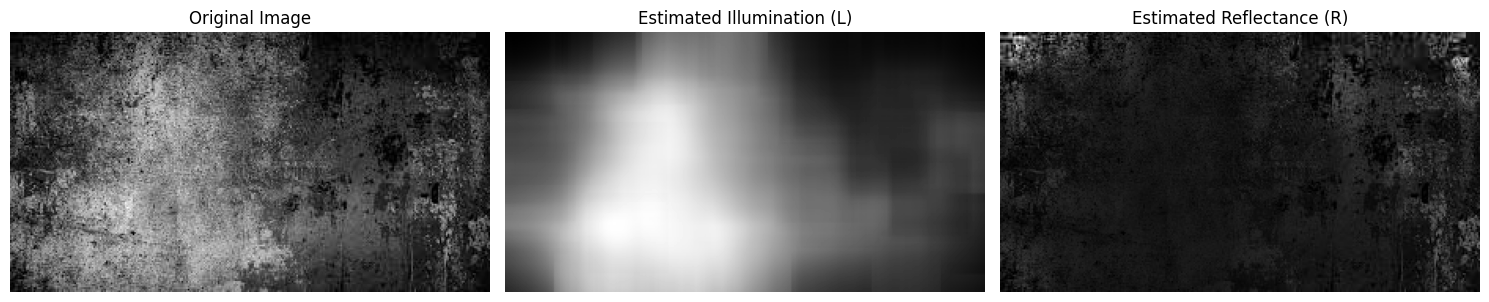

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

grayscale_img=('/kaggle/input/test-data-grayscale/textured-grayscale-1.jpeg')

def manual_convolve2d(img, kernel):
    """
    Performs a manual 2D convolution on a grayscale image.
    (This particular function is included for demonstration sake, and not optimized for speed.)
    """
    k_h, k_w = kernel.shape
    pad_y, pad_x = k_h // 2, k_w // 2

    # Extend image borders to manage edge pixels
    padded = np.pad(img, ((pad_y, pad_y), (pad_x, pad_x)), mode='edge')
    result = np.zeros_like(img)

    # Slide kernel across each pixel region
    for y in range(img.shape[0]):
        for x in range(img.shape[1]):
            region = padded[y:y + k_h, x:x + k_w]
            result[y, x] = np.sum(region * kernel)
    return result


def correct_illumination_grayscale(path, kernel_size=51):
    """
    Corrects uneven lighting in a grayscale image
    using a simplified Retinex-based approach.
    """
    # Load the image in grayscale mode
    gray = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if gray is None:
        print(f"Error: Unable to load image from '{path}'.")
        return

    # Convert to float and avoid log(0)
    gray_f = gray.astype(np.float32) + 1e-6

    # Step 1: Apply logarithmic transform
    log_img = np.log(gray_f)

    # Step 2: Create averaging kernel to estimate illumination
    kernel = np.ones((kernel_size, kernel_size), np.float32) / (kernel_size * kernel_size)

    # Step 3: Convolve log image with kernel
    log_light = manual_convolve2d(log_img, kernel)

    # Step 4: Compute log-reflectance
    log_reflect = log_img - log_light

    # Step 5: Reconstruct reflectance via exponentiation
    reflect = np.exp(log_reflect)

    # Step 6: Normalize illumination and reflectance for display
    cv2.normalize(reflect, reflect, 0, 255, cv2.NORM_MINMAX)
    reflect_img = reflect.astype(np.uint8)

    illum = np.exp(log_light)
    cv2.normalize(illum, illum, 0, 255, cv2.NORM_MINMAX)
    illum_img = illum.astype(np.uint8)

    # Step 7: Display results
    plt.figure(figsize=(15, 5))
    for i, (title, img) in enumerate([
        ('Original Image', gray),
        ('Estimated Illumination (L)', illum_img),
        ('Estimated Reflectance (R)', reflect_img)
    ]):
        plt.subplot(1, 3, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(title)
        plt.axis('off')

    plt.tight_layout()
    plt.show()


correct_illumination_grayscale(grayscale_img)

## Converting the Algorithm to Jointly Correct Illumination in Color Images While Preserving True Color Ratios  

To extend the grayscale homomorphic filtering (Retinex-based) algorithm for color images, it is important to **correct illumination jointly** across all RGB channels while **preserving true color ratios**, meaning the natural balance between the red, green, and blue intensities in textures should remain unchanged.  

The main challenge comes from **spectral variation**: the illumination components **(L_r, L_g, L_b)** differ across color channels. However, to maintain realistic colors, the algorithm avoids applying separate corrections to each channel individually.  

---

## Mathematical Strategy  

**Model:**  
For each channel, the image formation model is represented as:  
#### I_r(x, y) = R_r(x, y) × L_r(x, y)  
and similarly for the green and blue channels.  

**Joint Correction Approach:**  
To handle all channels together, the image is converted to **HSV color space**, where:  
- The **Value (V)** channel represents luminance (brightness).  
- The **Hue (H)** and **Saturation (S)** channels represent the color information (ratios of R/G/B).  

The **Multi-Scale Retinex (MSR)** method is then applied **only to the V channel**, leaving H and S unchanged. This ensures illumination is corrected **uniformly** while the **true color ratios** encoded in H and S are preserved.  

---

## MSR Process  

1. **Log Transform:** Take the logarithm of the V channel to convert multiplication into addition:  
   #### log(V) = log(R) + log(L)  

2. **Illumination Estimation:** Estimate log(L) using **multi-scale low-pass filters** (e.g., Gaussian blurs with varying kernel sizes).  

3. **Subtraction:** Subtract the estimated log(L) from log(V) to isolate the log-reflectance:  
   #### log(R̂) = log(V) - log(L̂)  

4. **Enhancement and Reconstruction:**  
   - Apply **gain adjustment** for brightness.  
   - Use the **exponent function** to revert to the normal scale.  
   - Normalize V for display.  
   - Optionally apply **gamma correction** for contrast control.  

---

### Why This Preserves Color Ratios  

Because **H** and **S** are left untouched, the **relative proportions** between the R, G, and B channels remain the same.  
The correction on the **V channel** adjusts only the brightness (illumination) while indirectly accounting for spectral variations in lighting.  

---

### Python Implementation  

The implementation uses manual convolution for low-pass filtering, following the same logic as the grayscale version.  

**Key Parameters:**  
- **Scales:** Multi-scale kernel sizes, e.g., [11, 51, 101], to capture different detail levels.  
- **Gain:** Controls brightness enhancement.  
- **Gamma:** Adjusts overall contrast.  

**Output:**  
The algorithm displays the **original** and **corrected** images side by side. The corrected image shows **uniform illumination** and **naturally preserved colors**.  

This extended approach effectively handles **color illumination correction** while maintaining the **authentic texture colors**, thereby providing a complete solution to the given problem.


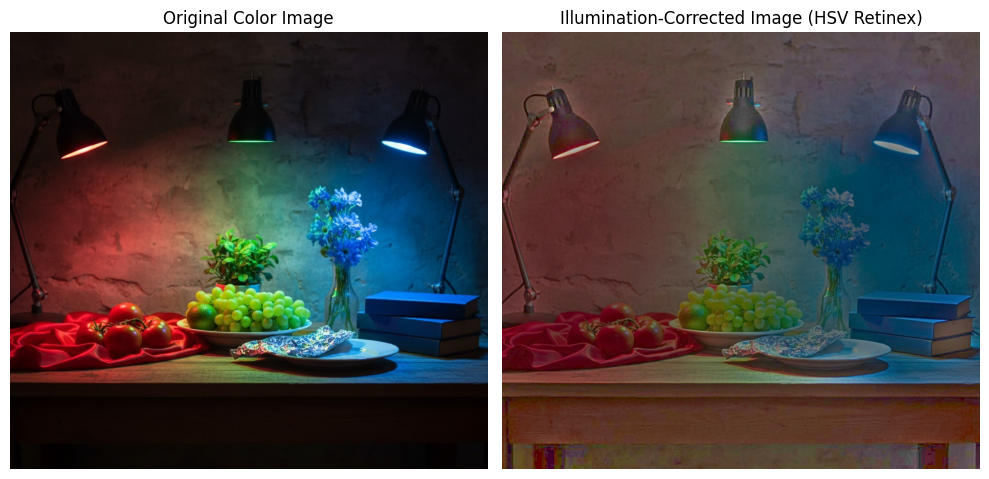

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

color_img=('/kaggle/input/color-test-img/color-2.jpg')

def manual_convolve2d(img, kernel):
    """
    Performs a manual 2D convolution on a grayscale image.
    (Included for conceptual clarity; slower than built-in functions.)
    """
    k_h, k_w = kernel.shape
    pad_y, pad_x = k_h // 2, k_w // 2

    # Extend image borders to handle boundary pixels
    padded = np.pad(img, ((pad_y, pad_y), (pad_x, pad_x)), mode='edge')
    result = np.zeros_like(img)

    # Slide the kernel window across each pixel location
    for y in range(img.shape[0]):
        for x in range(img.shape[1]):
            region = padded[y:y + k_h, x:x + k_w]
            result[y, x] = np.sum(region * kernel)
    return result


def correct_illumination_color(path, scales=[11, 51, 101], gain=2.0):
    """
    Corrects uneven lighting in a color image using a Multi-Scale Retinex approach.
    Operates on the Value (V) channel in HSV space to preserve the true color balance.
    """
    # 1. Load image in color mode
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    if img is None:
        print(f"Error: Unable to load image from '{path}'.")
        return

    # 2. Convert to HSV to isolate brightness from color components
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    # 3. Work on the Value channel (V) for illumination correction
    v_f = v.astype(np.float32) + 1e-6
    log_v = np.log(v_f)

    # 4. Estimate illumination at multiple spatial scales
    # Large kernels capture broader illumination trends
    log_light_scales = []
    for scale in scales:
        kernel = np.ones((scale, scale), np.float32) / (scale * scale)
        log_light = manual_convolve2d(log_v, kernel)
        log_light_scales.append(log_light)
    log_light_avg = np.mean(log_light_scales, axis=0)

    # 5. Compute log-reflectance and enhance using a gain factor
    log_reflect = log_v - log_light_avg + gain
    reflect = np.exp(log_reflect)

    # 6. Normalize corrected reflectance to fit displayable range
    cv2.normalize(reflect, reflect, 0, 255, cv2.NORM_MINMAX)
    v_corrected = reflect.astype(np.uint8)

    # 7. Merge corrected V channel back with original H and S
    hsv_corrected = cv2.merge([h, s, v_corrected])
    corrected_img = cv2.cvtColor(hsv_corrected, cv2.COLOR_HSV2BGR)

    # 8. Optional: gamma adjustment for better brightness balance
    gamma = 0.6  # lower gamma increases contrast slightly
    corrected_img = np.power(corrected_img / 255.0, gamma) * 255
    corrected_img = corrected_img.astype(np.uint8)

    # 9. Visual comparison of original and corrected images
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('Original Color Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(corrected_img, cv2.COLOR_BGR2RGB))
    plt.title('Illumination-Corrected Image (HSV Retinex)')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

correct_illumination_color(color_img)
